Epoch  50 | Loss: 0.2818
Epoch 100 | Loss: 0.2796
Epoch 150 | Loss: 0.2748
Epoch 200 | Loss: 0.2746
Epoch 250 | Loss: 0.2761
Epoch 300 | Loss: 0.2767


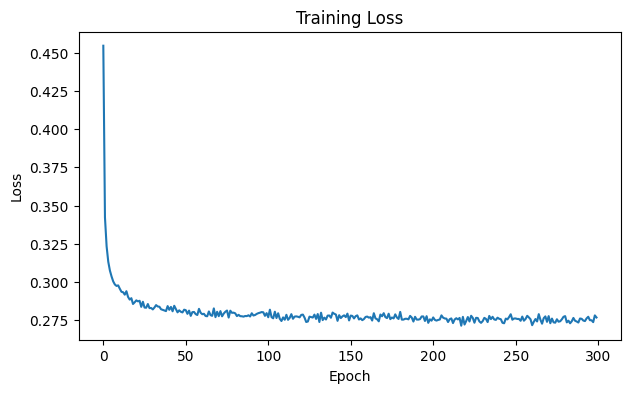

Test Accuracy: 88.66%


In [4]:
# ============================================================
#  Census Income Binary Classification – PyTorch
#  NOTE: Add your own markdown explanations between cells!
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# ---------- 1. Reproducibility ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# ---------- 2. Load Data ----------
df = pd.read_csv("income.csv")

# Separate columns
cat_cols  = ['sex','education','marital-status','workclass','occupation']
cont_cols = ['age','hours-per-week']
y_col     = 'label'

# ---------- 3. Category dtype ----------
for col in cat_cols:
    df[col] = df[col].astype('category')

# ---------- 4. Embedding sizes ----------
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]  # rule of thumb

# ---------- 5. Arrays & Tensors ----------
cats  = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
conts = np.stack([df[col].values for col in cont_cols], axis=1)
labels = df[y_col].values

cats  = torch.tensor(cats,  dtype=torch.int64)
conts = torch.tensor(conts, dtype=torch.float32)
y     = torch.tensor(labels, dtype=torch.int64)

# ---------- 6. Train / Test Split ----------
X_cat_train, X_cat_test, \
X_con_train, X_con_test, \
y_train, y_test = train_test_split(
    cats, conts, y, test_size=5000, random_state=seed
)

# ---------- 7. DataLoader ----------
train_ds = TensorDataset(X_cat_train, X_con_train, y_train)
test_ds  = TensorDataset(X_cat_test,  X_con_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=64)

# ---------- 8. Model ----------
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(cat, sz) for cat, sz in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum(e[1] for e in emb_szs)
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeds)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

model = TabularModel(emb_szs, n_cont=len(cont_cols), out_sz=2,
                     layers=[50], p=0.4)

# ---------- 9. Loss & Optimizer ----------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---------- 10. Training Loop ----------
train_losses = []
for epoch in range(300):
    model.train()
    epoch_loss = 0.0
    for xb_cat, xb_cont, yb in train_dl:
        optimizer.zero_grad()
        out = model(xb_cat, xb_cont)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dl))
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {train_losses[-1]:.4f}")

# ---------- 11. Plot Loss ----------
plt.figure(figsize=(7,4))
plt.plot(train_losses)
plt.title("Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

# ---------- 12. Evaluation ----------
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for xb_cat, xb_cont, yb in test_dl:
        outputs = model(xb_cat, xb_cont)
        loss = criterion(outputs, yb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
